In [ ]:
## Import needed libraries
!pip install yfinance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from __future__ import division
from numpy import linspace, loadtxt, ones, convolve
import requests 

import yfinance as yf
from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.tree import plot_tree

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter("ignore") # for GridSearchCV

     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 6.4 MB 43.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def get_yfinance_data(ticker, period):
  ticker = yf.Ticker(ticker)
  data = ticker.history(period=period)
  data.index = pd.to_datetime(data.index, format='%Y%m%d', errors='ignore')
  return data

## Define a function that will return the moving avarage of our features (open, volume, close, etc)
def movingaverage(ts, timerange):
    window= np.ones(int(timerange))/float(timerange)
    return np.convolve(ts, window, 'same')

def get_financial_indicators(Data):
  #create a column for the daily returns
  Data['returns'] = np.log(Data['Close'] / Data['Close'].shift(1) )

  #calculate the movement on the price based on the closing price of the previous day
  Data['movement'] = Data['Close'] - Data['Close'].shift(1)

  # Create up and down indicators that will give numbers between 0 and 1 as %'s
  Data['up'] = np.where((Data['movement'] > 0) ,Data['movement'],0)

  Data['down'] = np.where((Data['movement'] < 0) ,Data['movement'],0)


  Data['pct_change'] = Data.returns.pct_change()
  Data['log_ret'] = np.log(Data.returns) - np.log(Data.returns.shift(1))

  return Data


def get_time_series(Data, selected_feature):
  Data['date'] = Data.index
  df_ts = Data.rename(columns={'date':'ds', 'Close':'ts'})
  return df_ts

In [ ]:
###  Select Ticker and time 
df = get_yfinance_data('AAPL', '3y')
df = get_financial_indicators(df)
df.shape

(4023, 13)

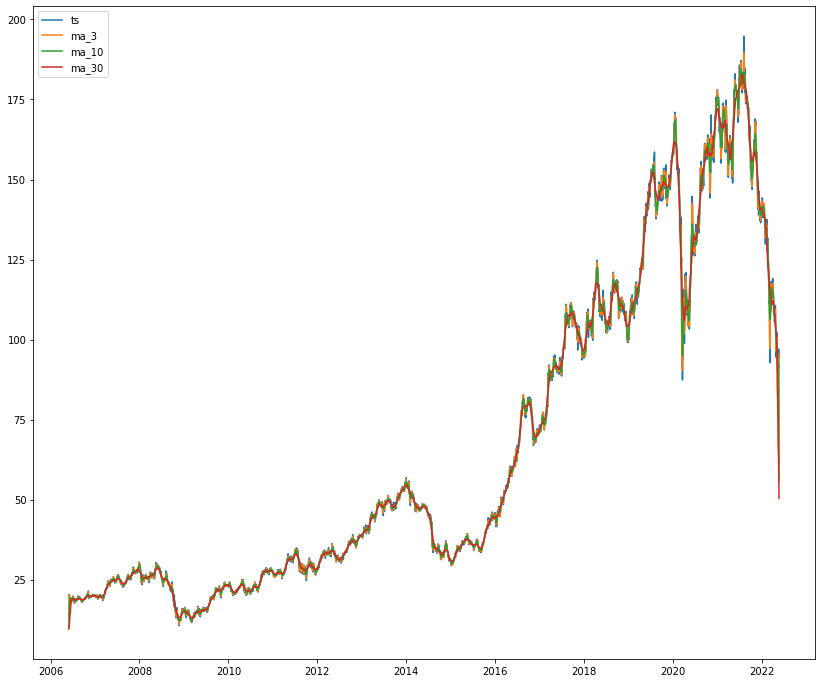

In [ ]:
### Select Feature to be analysed and predicted 
selected_feature = df['Close']


### Create moving average indicators 
df['moving_avarage_3'] = movingaverage(selected_feature, 3)
df['moving_avarage_10'] = movingaverage(selected_feature, 10)
df['moving_avarage_30'] = movingaverage(selected_feature, 30)


df_ts = get_time_series(df, selected_feature)
y = pd.DataFrame({'ts':df_ts['ts'],  'ma_3':df['moving_avarage_3'], 'ma_10':df['moving_avarage_10'], 'ma_30':df['moving_avarage_30']})
plt.figure(figsize=(14,12))
plt.plot(df_ts['ds'], y)
plt.legend(y.columns)
plt.show()

In [ ]:
df['trade_classes'] = df['pct_change'].apply(lambda x: 1 if x>0 else x)
df['trade_classes'] = df['trade_classes'].apply(lambda x: 0 if x<0 else x)
df = df.reindex(index=df.index[::-1])
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,movement,up,down,pct_change,log_ret,moving_avarage_3,moving_avarage_10,moving_avarage_30,date,trade_classes
Date,,,,,,,,,,,,,,,,,,
2022-05-20,91.970001,92.430000,90.120003,91.360001,96100,0.0,0.0,0.000657,0.059998,0.059998,0.000000,-0.857526,-1.948598,60.886668,55.945000,50.433741,2022-05-20,0.0
2022-05-19,89.959999,92.000000,89.480003,91.300003,136900,0.0,0.0,0.004611,0.420006,0.420006,0.000000,-1.070306,NaN,91.180000,65.046899,53.685027,2022-05-19,0.0
2022-05-18,93.419998,93.550003,90.849998,90.879997,86600,0.0,0.0,-0.065583,-6.160004,0.000000,-6.160004,-3.131735,NaN,93.073334,74.179192,56.833045,2022-05-18,0.0
2022-05-17,98.129997,98.300003,96.089996,97.040001,132200,0.0,0.0,0.030765,2.940002,2.940002,0.000000,-5.336286,NaN,94.006666,83.201680,60.068317,2022-05-17,0.0
2022-05-16,93.199997,94.750000,92.709999,94.099998,132100,0.0,0.0,-0.007095,-0.669998,0.000000,-0.669998,-1.175682,NaN,95.303332,92.186914,63.479079,2022-05-16,0.0


## Forecast 

### - The forecast will be done using the ARIMA method 
### - stationarity tests will be used to identify stationarity in original data and in the two moving avarage columns previously created 
### - Decomposition will be used to indentify trend and sesonality

In [ ]:
def test_stationarity(data, ts):
  # rolling stats
  rolmean = data[ts].rolling(window=12, center=False).mean()
  rolstd = data[ts].rolling(window=12, center=False).std()

  #plot rolling stats
  orig = plt.plot(data[ts], color= 'blue',label='original')
  std = plt.plot(rolstd, color='black', label = 'Rolling Std')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')

  plt.legend(loc='best')
  plt.title('Rolling Mean & Std Deviation for %s' %(ts))
  plt.xticks(rotation = 45)
  plt.show(block=False)
  plt.close()

  #Perform Dickey-Fuller test:
  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(data[ts], autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)


def run_arima(data, ts, p, d, q):
  model = ARIMA(data[ts], order=(p,d,q))
  results_arima=model.fit(disp=-1)

  len_results= len(results_arima.fittedvalues)
  ts_modified = data[ts][-len_results:]

  rss = sum((results_arima.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss/len(data[ts]))
  print('rmse', rmse)
  plt.figure()
  plt.plot(data[ts])
  plt.plot(results_arima.fittedvalues, color = 'red')

  plt.show()

  return results_arima

def plot_decomposition(data, ts, trend, seasonal, resid):
  plt.figure()
  f, ((ax1, ax2), (ax3,ax4))= plt.subplots(2,2, figsize=(15,5), sharex= True)

  ax1.plot(data['ts'], label= 'Original')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis='x', rotation=45)

  ax2.plot(data['trend'], label= 'Trend')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis='x', rotation=45)

  ax3.plot(data['seasonal'], label= 'Seasonality')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis='x', rotation=45)

  ax4.plot(data['resid'], label= 'Residual')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis='x', rotation=45)

  plt.tight_layout()

  plt.show()

def get_selected_days_forecast(Model, number_of_days):
  days = str(number_of_days)
  my_forcast = Model.forecast(number_of_days)
  plt.figure()
  fuel=plt.plot(my_forcast[0], color= 'blue',label='Forecas')
  plt.legend(loc='best')
  plt.xlabel('Days')
  plt.ylabel('Units')
  plt.title(days+' Days Forecast')

  plt.figure()
  fuel=plt.plot(my_forcast[1], color= 'red',label='Error')
  plt.legend(loc='best')
  plt.xlabel('Days')
  plt.ylabel('Units')
  plt.title('Error of '+days+' Days Forecast')

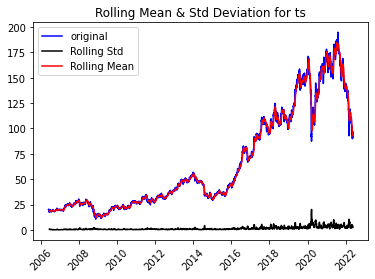

Results of Dickey-Fuller Test:
Test Statistic                   -1.168870
p-value                           0.686842
#Lags Used                       29.000000
Number of Observations Used    3993.000000
Critical Value (1%)              -3.431989
Critical Value (5%)              -2.862264
Critical Value (10%)             -2.567155
dtype: float64


In [ ]:
test_stationarity(df_ts,'ts')

<Figure size 432x288 with 0 Axes>

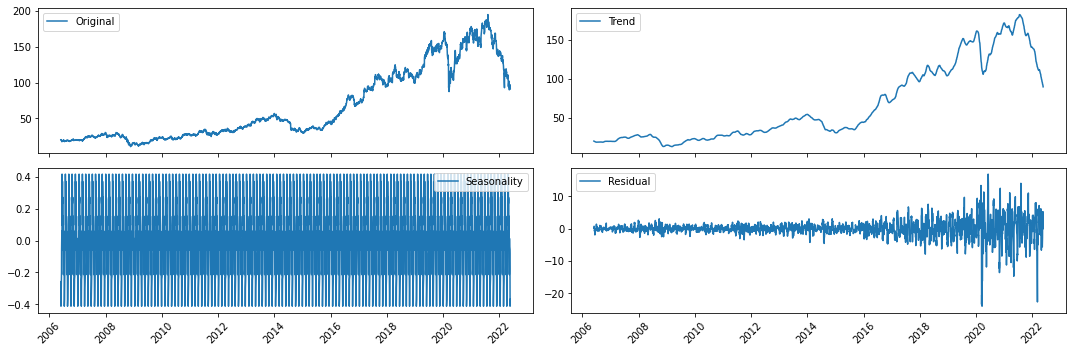

In [ ]:
df_ts = df_ts
###from the decomposition it is possible to obtain important details abput trand, residuals, and about sesonality 
decomposition = seasonal_decompose(df_ts['ts'], freq= 30, extrapolate_trend=2)


new_data = df_ts
new_data.loc[:,'trend']= decomposition.trend
new_data.loc[:,'seasonal']= decomposition.seasonal
new_data.loc[:,'resid']= decomposition.resid


plot_decomposition(new_data, new_data['ts'], new_data['trend'], new_data['seasonal'], new_data['resid'])

rmse 1.4442427466456975


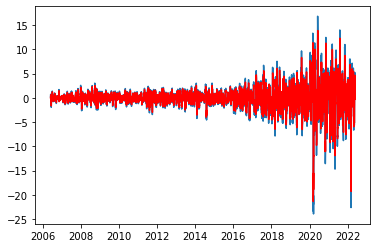

In [ ]:
model_AR = run_arima(new_data, 'resid', p=4, d=0, q=0)

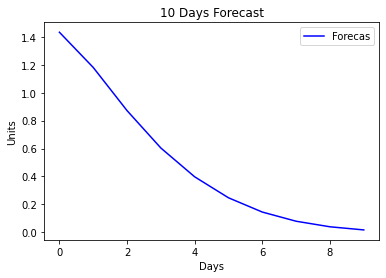

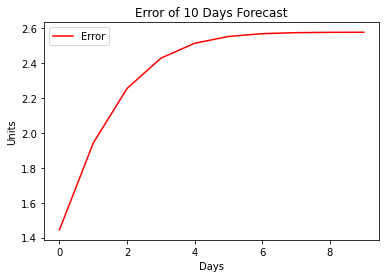

In [ ]:
get_selected_days_forecast(model_AR, 10)

## Build Classifier 

In [ ]:
### Balance binary classes 
def balance_trade_class(Data):

  increase_count = len(Data[Data['trade_classes'] == 1])
  decrease_count = len(Data[Data['trade_classes'] == 0])

  sampled_decrease = Data[Data['trade_classes'] == 0].sample(n=increase_count)
  increase = Data[Data['trade_classes'] == 1]

  sampled_decrease.reset_index(drop=True, inplace=True)
  increase.reset_index(drop=True, inplace=True)

  balanced_df = pd.concat([sampled_decrease, increase]).reset_index(drop=True)

  return balanced_df

## Find correlations with the target variable:
def get_correlations(data):
  corr = data.corr()
  return corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

class KNNClassifier():
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X, K, epsilon=1e-4):
        N = len(X)
        y_hat = np.zeros(N)
        
        for i in range(N):
            dist2 = np.sum((self.X-X[i])**2, axis=1)
            self.idxt = np.argsort(dist2)[:K] 
            gamma_k = 1/(np.sqrt(dist2[self.idxt]+epsilon)) 
            y_hat[i] = np.bincount(self.y[self.idxt], weights=gamma_k).argmax()  ### 
            
        return y_hat

## get accuracy of model
def accuracy(y, y_hat):
  return np.mean(y==y_hat)

In [ ]:
# Remove columns not needed and cleen up Data 
df_classifier = df.drop(columns=['Dividends', 'Stock Splits', 'date', 'up', 'down', 'log_ret'])
df_classifier = df_classifier.dropna()
df_classifier.head()

,Open,High,Low,Close,Volume,returns,movement,pct_change,moving_avarage_3,moving_avarage_10,moving_avarage_30,trade_classes
Date,,,,,,,,,,,,
2022-05-20,91.970001,92.430000,90.120003,91.360001,96100,0.000657,0.059998,-0.857526,60.886668,55.945000,50.433741,0.0
2022-05-19,89.959999,92.000000,89.480003,91.300003,136900,0.004611,0.420006,-1.070306,91.180000,65.046899,53.685027,0.0
2022-05-18,93.419998,93.550003,90.849998,90.879997,86600,-0.065583,-6.160004,-3.131735,93.073334,74.179192,56.833045,0.0
2022-05-17,98.129997,98.300003,96.089996,97.040001,132200,0.030765,2.940002,-5.336286,94.006666,83.201680,60.068317,0.0
2022-05-16,93.199997,94.750000,92.709999,94.099998,132100,-0.007095,-0.669998,-1.175682,95.303332,92.186914,63.479079,0.0


In [ ]:
### Check the Data before ingesting it into machine learning models 
df_classifier.info()
df_classifier.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4020 entries, 2022-05-20 to 2006-06-02
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               4020 non-null   float64
 1   High               4020 non-null   float64
 2   Low                4020 non-null   float64
 3   Close              4020 non-null   float64
 4   Volume             4020 non-null   int64  
 5   returns            4020 non-null   float64
 6   movement           4020 non-null   float64
 7   pct_change         4020 non-null   float64
 8   moving_avarage_3   4020 non-null   float64
 9   moving_avarage_10  4020 non-null   float64
 10  moving_avarage_30  4020 non-null   float64
 11  trade_classes      4020 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 408.3 KB


Open                 0
High                 0
Low                  0
Close                0
Volume               0
returns              0
movement             0
pct_change           0
moving_avarage_3     0
moving_avarage_10    0
moving_avarage_30    0
trade_classes        0
dtype: int64

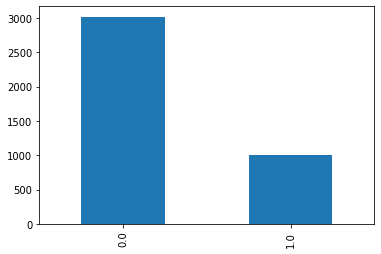

In [ ]:
## Check if the classes are balanced
df_classifier['trade_classes'].value_counts().plot(kind='bar')

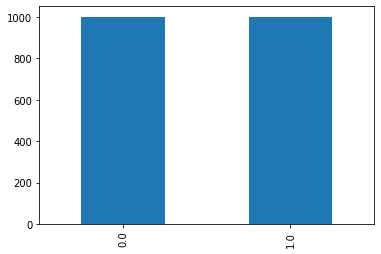

In [ ]:
balanced_df = balance_trade_class(df_classifier)
balanced_df['trade_classes'].value_counts().plot(kind='bar')

In [ ]:
## Find correlations with the target variable:
get_correlations(balanced_df)

,Open,High,Low,Close,Volume,returns,movement,pct_change,moving_avarage_3,moving_avarage_10,moving_avarage_30,trade_classes
Open,1.00,1.00,1.00,1.00,0.05,-0.00,0.01,-0.05,1.00,1.00,1.00,-0.05
High,1.00,1.00,1.00,1.00,0.05,0.00,0.01,-0.05,1.00,1.00,1.00,-0.05
Low,1.00,1.00,1.00,1.00,0.05,0.00,0.01,-0.05,1.00,1.00,1.00,-0.05
Close,1.00,1.00,1.00,1.00,0.05,0.00,0.01,-0.05,1.00,1.00,1.00,-0.05
Volume,0.05,0.05,0.05,0.05,1.00,-0.05,-0.05,0.00,0.05,0.05,0.05,0.03
returns,-0.00,0.00,0.00,0.00,-0.05,1.00,0.77,-0.01,-0.01,-0.01,-0.01,-0.01
movement,0.01,0.01,0.01,0.01,-0.05,0.77,1.00,-0.02,0.00,-0.01,-0.01,-0.01
pct_change,-0.05,-0.05,-0.05,-0.05,0.00,-0.01,-0.02,1.00,-0.05,-0.05,-0.05,0.26
moving_avarage_3,1.00,1.00,1.00,1.00,0.05,-0.01,0.00,-0.05,1.00,1.00,1.00,-0.05
moving_avarage_10,1.00,1.00,1.00,1.00,0.05,-0.01,-0.01,-0.05,1.00,1.00,1.00,-0.05


###Modeling

In [ ]:
balanced_df.replace([np.inf, -np.inf], 0, inplace=True)
balanced_df

,Open,High,Low,Close,Volume,returns,movement,pct_change,moving_avarage_3,moving_avarage_10,moving_avarage_30,trade_classes
0,46.712940,46.978655,46.712940,46.881226,14500,0.003975,0.186001,-0.886844,47.347703,47.255887,47.994282,0.0
1,27.319746,27.944875,27.235271,27.885738,7900,0.049684,1.351625,-3.969283,27.432379,27.427873,27.900097,0.0
2,137.879891,138.859974,137.200634,138.471817,39400,0.017896,2.455994,-2.143790,136.019699,135.967929,133.034458,0.0
3,55.499292,55.525862,55.198146,55.348721,154300,-0.027464,-1.541153,-10.270567,55.685294,55.498407,54.541237,0.0
4,27.203014,27.486112,27.048599,27.177279,17200,0.016229,0.437513,-0.241668,27.603352,27.371155,28.412608,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1997,18.842220,18.842220,18.520131,18.842220,30800,0.008584,0.161041,0.987040,18.775120,18.757672,18.993869,1.0
1998,18.922741,18.922741,18.399346,18.922741,12300,0.054659,1.006531,1.404887,18.520128,18.598639,16.552031,1.0
1999,17.513601,18.318824,17.513601,17.513601,2500,-0.066691,-1.207832,2.577383,18.050415,18.754651,15.262332,1.0
2000,18.751633,18.751633,18.328891,18.751633,14400,-0.034295,-0.654243,1.466048,19.077077,19.173367,13.306982,1.0


In [ ]:
## Define X and y
y = balanced_df['trade_classes']
X = balanced_df[['Volume', 'pct_change']]
y = y.astype(int)

#Normalize Data:
#X = X/X.max()

y = y.to_numpy()
X = X.to_numpy()

### split the data into train and test 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1601, 2)
(401, 2)
(1601,)
(401,)


###KNN Classifier

In [ ]:
## Call model and fit X and y in K-NN Classifier 
knn = KNNClassifier()
knn.fit(X_train, y_train)

eps=1e8
K = 2
y_train_hat = knn.predict(X_train, K, eps)
print('The training accuracy is: ', accuracy(y_train, y_train_hat))

y_test_hat = knn.predict(X_test, K, eps)

print('The testing accuracy is: ', accuracy(y_test, y_test_hat))

The training accuracy is:  1.0
The testing accuracy is:  0.6683291770573566


###Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       202
           1       1.00      0.99      0.99       199

    accuracy                           1.00       401
   macro avg       1.00      0.99      1.00       401
weighted avg       1.00      1.00      1.00       401



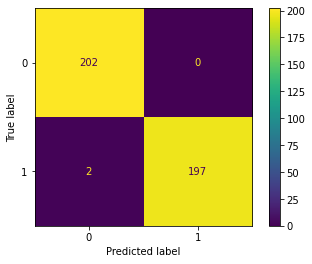

In [ ]:
### Apply Decision Tree Classifier

dt_clf = DecisionTreeClassifier(random_state=1)

dt_clf = dt_clf.fit(X_train,y_train)

y_hat = dt_clf.predict(X_test)

print(metrics.classification_report(y_test, y_hat))

##plot confusion matrix
metrics.plot_confusion_matrix(dt_clf, X_test, y_test)

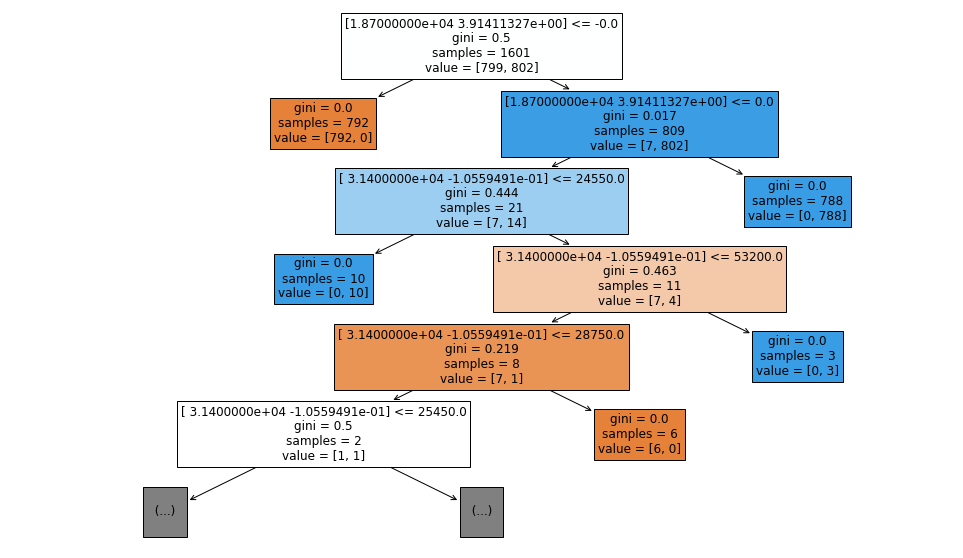

In [ ]:
## Visualize Decision Tree
fig = plt.figure(figsize=(17,10))
_ = plot_tree(dt_clf, max_depth=5, feature_names=list(X_train), filled=True, fontsize=12)

### Logistic Regression 

In [ ]:
##### Logistic Regression 

param_grid=[{'C': np.logspace(3,5,10)},
           {'penalty': ['l1', 'l2']},
           {'solver': ['lbfgs', 'liblinear', 'adam']},
          {'max_iter': [1000000]}]

lr = LogisticRegression()

grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv=10, scoring='recall', refit=True) # you can change scoring function that will impact the estimator
grid = grid.fit(X_train, y_train)
print('Best estimator: {}\nWeights: {}, Intercept: {}\nBest params: {}\nScorer: {}'.format(grid.best_estimator_, grid.best_estimator_.coef_, grid.best_estimator_.intercept_,grid.best_params_, grid.scorer_))
print('Available parameters for the estimator (fine-tuning): ',lr.get_params().keys())

Best estimator: LogisticRegression()
Weights: [[-9.62560426e-08  7.71645621e+00]], Intercept: [0.62230923]
Best params: {'penalty': 'l2'}
Scorer: make_scorer(recall_score, average=binary)
Available parameters for the estimator (fine-tuning):  dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


In [ ]:
y_train_predict = grid.predict(X_train)
print("Training SET")
print("--------------------------------------")
print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}'.format(accuracy_score(y_train, y_train_predict), precision_score(y_train, y_train_predict), recall_score(y_train, y_train_predict), f1_score(y_train, y_train_predict)))
print("Confusion Matrix:\n {}".format(confusion_matrix(y_train, y_train_predict)))

# model evaluation for testing set
y_test_predict = grid.predict(X_test)

print("\nTesting SET")
print("--------------------------------------")
print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}'.format(accuracy_score(y_test, y_test_predict), precision_score(y_test, y_test_predict), recall_score(y_test, y_test_predict), f1_score(y_test, y_test_predict)))
print("Confusion Matrix:\n {}".format(confusion_matrix(y_test, y_test_predict)))

Training SET
--------------------------------------
Accuracy: 0.987, Precision: 0.974, Recall: 1.000, F1 Score: 0.987
Confusion Matrix:
 [[778  21]
 [  0 802]]

Testing SET
--------------------------------------
Accuracy: 0.990, Precision: 0.980, Recall: 1.000, F1 Score: 0.990
Confusion Matrix:
 [[198   4]
 [  0 199]]


ROC AUC (Training)=1.000
ROC AUC (Testing)=1.000


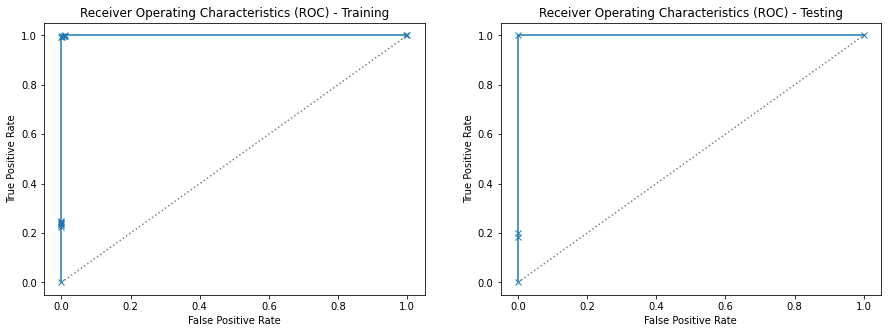

In [ ]:
# predict probabilities
lr_probs_train = grid.predict_proba(X_train)
lr_probs_test = grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs_train = lr_probs_train[:, 1]
lr_probs_test = lr_probs_test[:, 1]

print('ROC AUC (Training)={:.3f}'.format(roc_auc_score(y_train, lr_probs_train)))
print('ROC AUC (Testing)={:.3f}'.format(roc_auc_score(y_test, lr_probs_test)))

lr_fpr_train, lr_tpr_train, _ = roc_curve(y_train, lr_probs_train)
lr_fpr_test, lr_tpr_test, _ = roc_curve(y_test, lr_probs_test)

# plot the roc curve for the training set
_ = plt.figure(figsize=(15, 5))
ax1 =plt.subplot(121)
_ = ax1.plot(lr_fpr_train, lr_tpr_train, marker='x')
_ = ax1.plot([0,1], [0, 1], 'gray', linestyle=':', marker='')
_ = ax1.set_title('Receiver Operating Characteristics (ROC) - Training')
_ = ax1.set_xlabel('False Positive Rate')
_ = ax1.set_ylabel('True Positive Rate')

# plot the roc curve for the testing set
ax2 = plt.subplot(122)
_ = ax2.plot(lr_fpr_test, lr_tpr_test, marker='x')
_ = ax2.plot([0,1], [0, 1], 'gray', linestyle=':', marker='')
_ = ax2.set_title('Receiver Operating Characteristics (ROC) - Testing')
_ = ax2.set_xlabel('False Positive Rate')
_ = ax2.set_ylabel('True Positive Rate')

##ANN

In [ ]:
### Sandardization of data ###
from sklearn.preprocessing import StandardScaler

# importing the libraries
from keras.models import Sequential
from keras.layers import Dense



PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
y = y.reshape(-1, 1)
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)

In [ ]:
# create ANN model and run it once 
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=256, input_dim=2, kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=128, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=64, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=8, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=4, kernel_initializer='normal', activation='relu'))
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')
 
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 20, epochs = 10, verbose=1)

Epoch 1/10
81/81 [==============================] - 2s 4ms/step - loss: 0.4261
Epoch 2/10
81/81 [==============================] - 0s 6ms/step - loss: 0.3643
Epoch 3/10
81/81 [==============================] - 0s 5ms/step - loss: 0.3250
Epoch 4/10
81/81 [==============================] - 0s 5ms/step - loss: 0.3003
Epoch 5/10
81/81 [==============================] - 0s 4ms/step - loss: 0.2813
Epoch 6/10
81/81 [==============================] - 0s 4ms/step - loss: 0.2701
Epoch 7/10
81/81 [==============================] - 0s 4ms/step - loss: 0.2622
Epoch 8/10
81/81 [==============================] - 0s 5ms/step - loss: 0.2583
Epoch 9/10
81/81 [==============================] - 0s 4ms/step - loss: 0.2544
Epoch 10/10
81/81 [==============================] - 0s 5ms/step - loss: 0.2524


In [ ]:
def run_ANN_on_batch_list_and_epoch_list(X_train, y_train, X_test, y_test):
    # Defining the list of hyper parameters to try
    batch_size_list=[24, 48, 64]
    epoch_list  =   [10, 20, 30, 40]
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])


    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=256, input_dim=2, kernel_initializer='normal', activation='relu'))
 
            model.add(Dense(units=128, kernel_initializer='normal', activation='relu'))
            model.add(Dense(units=64, kernel_initializer='normal', activation='relu'))
            model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
            model.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
            model.add(Dense(units=8, kernel_initializer='normal', activation='relu'))
            model.add(Dense(units=4, kernel_initializer='normal', activation='relu'))
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))
 
            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')
 
            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)
 
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)
 

# Calling the function
ResultsData=run_ANN_on_batch_list_and_epoch_list(X_train, y_train, X_test, y_test)

1 Parameters: batch_size: 24 - epochs: 10 Accuracy: -inf
2 Parameters: batch_size: 24 - epochs: 20 Accuracy: -inf
3 Parameters: batch_size: 24 - epochs: 30 Accuracy: -inf
4 Parameters: batch_size: 24 - epochs: 40 Accuracy: -inf
5 Parameters: batch_size: 48 - epochs: 10 Accuracy: -inf
6 Parameters: batch_size: 48 - epochs: 20 Accuracy: -inf
7 Parameters: batch_size: 48 - epochs: 30 Accuracy: -inf
8 Parameters: batch_size: 48 - epochs: 40 Accuracy: -inf
9 Parameters: batch_size: 64 - epochs: 10 Accuracy: -inf
10 Parameters: batch_size: 64 - epochs: 20 Accuracy: -inf
11 Parameters: batch_size: 64 - epochs: 30 Accuracy: -inf
12 Parameters: batch_size: 64 - epochs: 40 Accuracy: -inf
